In [46]:
#setup&imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.metrics import( classification_report, confusion_matrix, ConfusionMatrixDisplay,
                           f1_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, 
                           accuracy_score)

from xgboost import XGBClassifier
import traceback

In [2]:
#load_Titanic_Dataset(Seaborn)

df = sns.load_dataset('titanic')
df.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


In [8]:
#standardise columns and select features
#Features: pclass,sex,age,sibsp,parch,Fare,Embarked
#Target: Survived(0/1)

#create_copy

df_orig= df.copy()

#Normalise column names to lowercase for uniformity/consistency
df.columns= [c.strip().lower() for c in df.columns]

#Map common column names across seaborn/kaggle (selecting only which are required)
col_map= {
    "pclass":"pclass", "sex":"sex", "age":"age",
    "sibsp":"sibsp", "parch" : "parch", "fare":"fare", 
    "embarked":"embarked", "survived":"survived"}

#Ensuring required columns exist
required= ["pclass", "sex", "age","sibsp","parch", "fare", "embarked", "survived"]
missing= [c for c in required if c not in df.columns]

if missing:
    raise ValueError(f"Missing required columns in dataset: {missing}")

#keeping only selected feature set
feature_cols= ["pclass", "sex", "age","sibsp","parch", "fare", "embarked"]

X=df[feature_cols].copy()
y=df["survived"].astype(int)

print("X_shape:", X.shape, "| Y_shape:",y.shape)
X.head()

X_shape: (891, 7) | Y_shape: (891,)


,pclass,sex,age,sibsp,parch,fare,embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [9]:
#Preprocessing + One_hot_encoding +modelling

categorical_features= ["pclass", "sex", "embarked"]
numeric_features= ["age","sibsp", "parch", "fare"]

categorical_pipeline= Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse= True))
])

numeric_pipeline = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)) #allow sparse passthrough if needed
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_pipeline, categorical_features),
        ("num", numeric_pipeline, numeric_features),
    ],
    remainder="drop"
)

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",          
    tree_method="hist",         
    random_state=42,
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", xgb)
])
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=Fa

In [47]:
"""
NESTED CROSS-VALIDATION (5 outer folds × 3 inner folds)

- Outer loop (5 folds): Evaluates generalization performance on unseen folds.
- Inner loop (3 folds): Performs hyperparameter tuning using GridSearchCV within each outer training split.

Process:
1. For each outer fold:
   • Split data into outer training and test sets.
   • Use inner 3-fold CV on the training set to find best hyperparameters.
   • Evaluate the tuned model on the outer test fold.
   • Store metrics (F1, Precision, Recall, ROC AUC, Accuracy) and best parameters.
2. Aggregate results across outer folds (mean ± std).

Outcome:
Provides an unbiased estimate of model performance and hyperparameter stability.
"""

#NESTED CV: outer evaluation + inner tuning 
outer_rows = []                 
best_params_per_outer = []   


all_y_true = []
all_y_pred = []
all_y_proba = []

n_outer = outer_cv.get_n_splits()
print(f"Running nested CV: {n_outer} outer folds × {inner_cv.get_n_splits()} inner folds")

for fold_idx, (tr_idx, te_idx) in enumerate(outer_cv.split(X, y), start=1):
    print(f"\n=== Outer fold {fold_idx}/{n_outer} ===")
    try:
        # Split
        X_train, X_test = X.iloc[tr_idx], X.iloc[te_idx]
        y_train, y_test = y.iloc[tr_idx], y.iloc[te_idx]


        # Inner tuning
        grid = GridSearchCV(
            estimator=pipe, param_grid=param_grid, scoring="f1", cv=inner_cv, n_jobs=-1, refit=True, verbose=0)
        
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        # Evaluate on this outer test fold
        y_pred  = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]

        f1   = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec  = recall_score(y_test, y_pred)
        auc  = roc_auc_score(y_test, y_proba)
        acc  = accuracy_score(y_test, y_pred)

        # Append one row per completed outer fold
        outer_rows.append({
            "fold": fold_idx, "f1": f1, "precision": prec, "recall": rec, "roc_auc": auc, "accuracy": acc
        })
        best_params_per_outer.append(grid.best_params_)
        
        all_y_true.append(y_test.values)  # 1D np array
        all_y_pred.append(y_pred)
        all_y_proba.append(y_proba)

        print(f"[OHE+XGB] best={grid.best_params_} "
              f"| F1={f1:.4f} P={prec:.4f} R={rec:.4f} AUC={auc:.4f} Acc={acc:.4f}")

    except Exception as e:
        # Logging any error
        print(f"[Fold {fold_idx}] ERROR: {e.__class__.__name__}: {e}")
        traceback.print_exc()
        continue

# Build DataFrame AFTER the loop
outer_results = pd.DataFrame(outer_rows)
print("\nOuter results shape:", outer_results.shape)
display(outer_results)

y_true_cv  = np.concatenate(all_y_true)
y_pred_cv  = np.concatenate(all_y_pred)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["Not Survived", "Survived"]))   
                                        

Running nested CV: 5 outer folds × 3 inner folds

=== Outer fold 1/5 ===
[OHE+XGB] best={'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__reg_lambda': 2.0, 'clf__subsample': 1.0} | F1=0.7879 P=0.8254 R=0.7536 AUC=0.9082 Acc=0.8436

=== Outer fold 2/5 ===
[OHE+XGB] best={'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__reg_lambda': 2.0, 'clf__subsample': 0.8} | F1=0.7969 P=0.8500 R=0.7500 AUC=0.8996 Acc=0.8539

=== Outer fold 3/5 ===
[OHE+XGB] best={'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__reg_lambda': 2.0, 'clf__subsample': 0.8} | F1=0.7059 P=0.8235 R=0.6176 AUC=0.8399 Acc=0.8034

=== Outer fold 4/5 ===
[OHE+XGB] best={'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__reg_lambda': 1.0, 'clf__subsample': 0.8} | F1=0.7939 P=0.8254 R=0.7647

,fold,f1,precision,recall,roc_auc,accuracy
0,1,0.787879,0.825397,0.753623,0.908235,0.843575
1,2,0.796875,0.850000,0.750000,0.899599,0.853933
2,3,0.705882,0.823529,0.617647,0.839906,0.803371
3,4,0.793893,0.825397,0.764706,0.872126,0.848315
4,5,0.790698,0.850000,0.739130,0.885786,0.848315



Classification report:
              precision    recall  f1-score   support

Not Survived       0.85      0.92      0.88       109
    Survived       0.85      0.74      0.79        69

    accuracy                           0.85       178
   macro avg       0.85      0.83      0.84       178
weighted avg       0.85      0.85      0.85       178



In [40]:
# mean ± std over outer folds
summary = pd.concat(
    [outer_results.drop(columns=["fold"]).mean().to_frame("mean"),
     outer_results.drop(columns=["fold"]).std(ddof=1).to_frame("std")],
    axis=1
).round(4)

print("\n[OHE+XGB] Nested CV 5x3 — mean ± std over outer folds")
display(summary)

print("\nPer-outer-fold best params:")
for i, bp in enumerate(best_params_per_outer, 1):
    print(f"  Fold {i}: {bp}")


[OHE+XGB] Nested CV 5x3 — mean ± std over outer folds


,mean,std
f1,0.7750,0.0388
precision,0.8349,0.0138
recall,0.7250,0.0607
roc_auc,0.8811,0.0268
accuracy,0.8395,0.0205



Per-outer-fold best params:
  Fold 1: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__reg_lambda': 2.0, 'clf__subsample': 1.0}
  Fold 2: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__reg_lambda': 2.0, 'clf__subsample': 0.8}
  Fold 3: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__reg_lambda': 2.0, 'clf__subsample': 0.8}
  Fold 4: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__reg_lambda': 1.0, 'clf__subsample': 0.8}
  Fold 5: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__reg_lambda': 2.0, 'clf__subsample': 0.8}


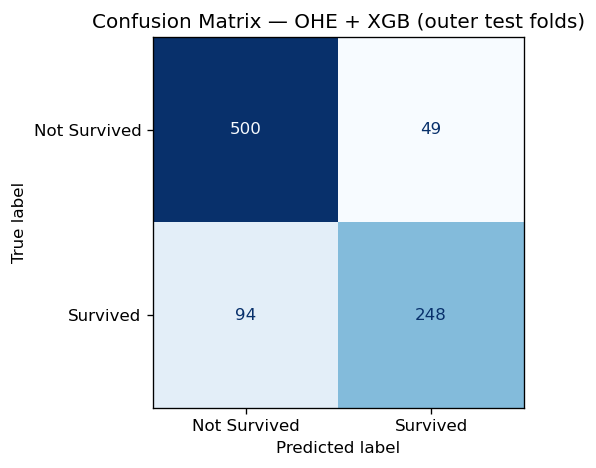

In [41]:
# Concatenate all outer-fold predictions
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

#confusion matrix
cm = confusion_matrix(y_true_cv, y_pred_cv, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Survived", "Survived"])

fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Confusion Matrix — OHE + XGB (outer test folds)")
plt.tight_layout()
plt.show()

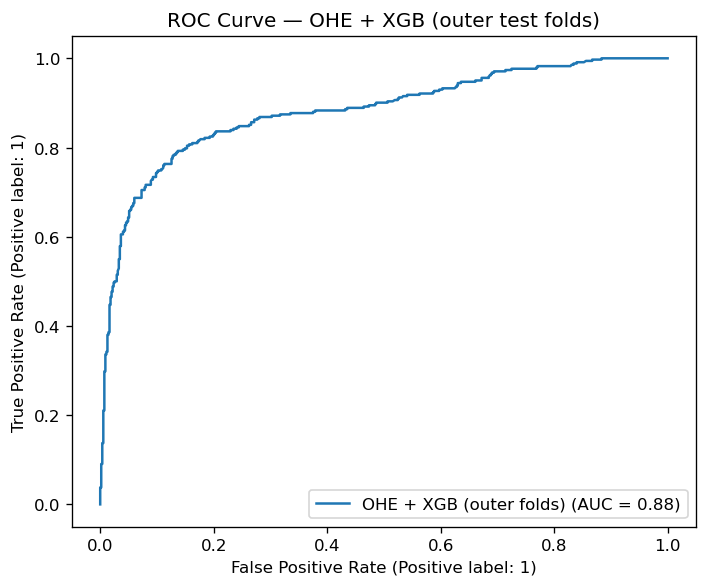

In [42]:
#ROC Curve (Binary) 

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
RocCurveDisplay.from_predictions(
    y_true_cv, y_proba_cv, name="OHE + XGB (outer folds)", ax=ax
)
plt.title("ROC Curve — OHE + XGB (outer test folds)")
plt.tight_layout()
plt.show()

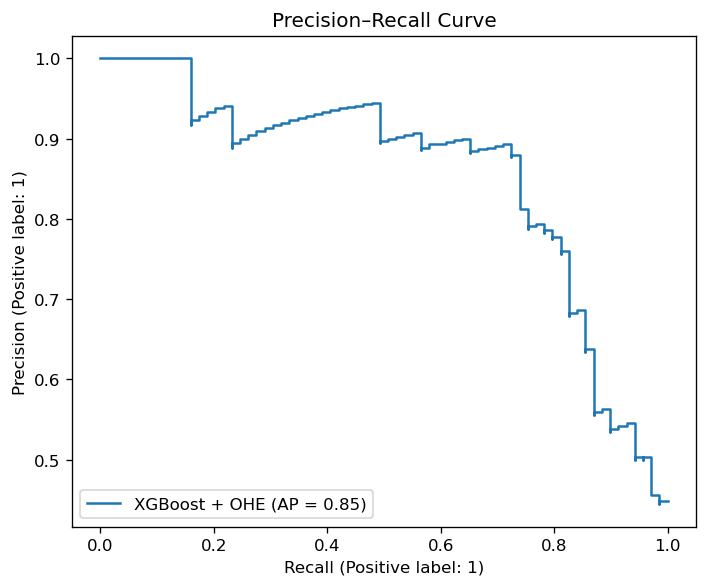

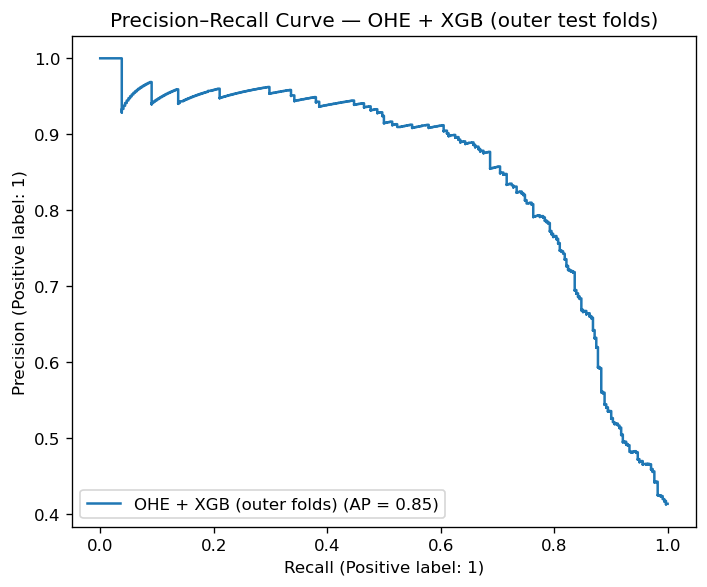

In [43]:
#ROC and Precision–Recall curves from outer-fold predictions

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
PrecisionRecallDisplay.from_estimator(
    best_model, X_test, y_test, ax=ax, name="XGBoost + OHE"
)
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
PrecisionRecallDisplay.from_predictions(
    y_true_cv, y_proba_cv, name="OHE + XGB (outer folds)", ax=ax
)
plt.title("Precision–Recall Curve — OHE + XGB (outer test folds)")
plt.tight_layout()
plt.show()


In [44]:

# Saving raw outer-fold results and summary

outer_results.to_csv("titanic_ohe_xgb_nested_outer_results.csv", index=False)
summary.to_csv("titanic_ohe_xgb_nested_summary.csv")
print("Saved CSVs: titanic_ohe_xgb_nested_outer_results.csv, titanic_ohe_xgb_nested_summary.csv")


Saved CSVs: titanic_ohe_xgb_nested_outer_results.csv, titanic_ohe_xgb_nested_summary.csv


In [45]:
#Save the Best Model


import joblib
joblib.dump(best_model, "titanic_ohe_xgb_best_model.joblib")


['titanic_ohe_xgb_best_model.joblib']